#dependencies

In [84]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline  
import seaborn as sns


from sklearn.model_selection import train_test_split
import keras
from tensorflow.keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.optimizers import Nadam, Adam
from keras.utils import to_categorical
from keras.layers import Dropout, Flatten, Input, Dense
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization

import random
import tensorflow as tf
import cv2
import os 
import glob
from keras import applications

#Functions

In [85]:
def display_img(image,title='Image',x_label=None,y_label=None,cmap_type='gray',show_axis=False,colorBar=False,F_size=(8,6)):
  plt.figure(figsize=F_size)
  plt.imshow(image,cmap=cmap_type)
  plt.title(title)
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  if colorBar: plt.colorbar()
  if not show_axis: plt.axis('off')
  plt.show()

def count_0_1(array):

  count1,count0 = 0,0

  for element in array:

    if element == 1:
      count1+=1
    else:
      count0+=1
  
  return count0,count1


#Loading the dataset

In [86]:
select_images_randomly = False

#Get images from google drive
directory_path_malignos = '/content/drive/MyDrive/cropped_and_treated_nods_maligno/'
directory_path_benignos = '/content/drive/MyDrive/cropped_and_treated_nods_benigno/'

directory_files = os.listdir(directory_path_malignos)
array_of_images_malignos = [plt.imread( os.path.join(directory_path_malignos,file) ) for file in directory_files]

directory_files = os.listdir(directory_path_benignos)
array_of_images_benignos = [plt.imread( os.path.join(directory_path_benignos,file) ) for file in directory_files]

print(f'Number of cropped maligno images: {len(array_of_images_malignos)}')
print(f'Number of cropped benigno images: {len(array_of_images_benignos)}')


Number of cropped maligno images: 262
Number of cropped benigno images: 275


#Spliting the dataset into training and test set.

In [87]:
x = np.array([*array_of_images_malignos,*array_of_images_benignos])
y = np.array([*[1 for _ in array_of_images_malignos],*[0 for _ in array_of_images_benignos]])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42,shuffle=True)

x_train = tf.expand_dims(x_train, axis=-1) #Do I need to do that transformation?
x_test = tf.expand_dims(x_test, axis=-1)
y_train = tf.expand_dims(y_train, axis=-1)
y_test = tf.expand_dims(y_test, axis=-1)

print(f'Size of training set {len(y_train)}')
count0,count1=count_0_1(y_train)
print(f'class 0 size: {count0} class 1 size: {count1}. ratio: {count1/(count0+count1)}')
print(f'Size of test set {len(y_test)}')
count0,count1=count_0_1(y_test)
print(f'class 0 size: {count0} class 1 size: {count1}. ratio: {count1/(count0+count1)}')

Size of training set 429
class 0 size: 223 class 1 size: 206. ratio: 0.4801864801864802
Size of test set 108
class 0 size: 52 class 1 size: 56. ratio: 0.5185185185185185


#Building the model and perfoming the simulations

##Model 1

In [88]:
model = keras.Sequential()

model.add(keras.layers.Conv2D( filters=64,kernel_size=5,padding = 'same',activation='relu',input_shape = (44,44,1) ))
model.add(keras.layers.MaxPooling2D(pool_size=[2,2],strides=2))

#model.add(keras.layers.Conv2D( filters=64,kernel_size=5,padding = 'same',activation='relu',input_shape = (44,44,1) ))
#model.add(keras.layers.MaxPooling2D(pool_size=[2,2],strides=2))

model.add(keras.layers.Conv2D( filters=32,kernel_size=3,padding = 'same',activation='relu',input_shape = (44,44,1) ))
model.add(keras.layers.MaxPooling2D(pool_size=[2,2],strides=2))

model.add(keras.layers.Flatten())

model.add(Dense(15, activation= 'relu'))
model.add(Dense(10, activation= 'relu'))
model.add(Dense(5, activation= 'softmax'))

model.compile(loss= "sparse_categorical_crossentropy",metrics=['accuracy'])
model.summary()
history = model.fit(x_train,y_train , epochs = 10, initial_epoch = 0,validation_split=0.2)

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_64 (Conv2D)          (None, 44, 44, 64)        1664      
                                                                 
 max_pooling2d_62 (MaxPoolin  (None, 22, 22, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_65 (Conv2D)          (None, 22, 22, 32)        18464     
                                                                 
 max_pooling2d_63 (MaxPoolin  (None, 11, 11, 32)       0         
 g2D)                                                            
                                                                 
 flatten_25 (Flatten)        (None, 3872)              0         
                                                                 
 dense_65 (Dense)            (None, 15)              

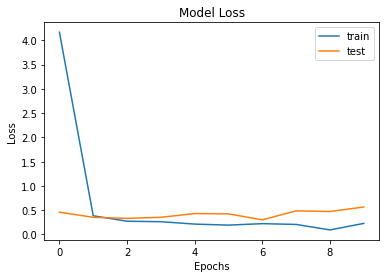

4/4 [==============================] - 0s 31ms/step - loss: 0.7145 - accuracy: 0.7870


In [89]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

evaluation = model.evaluate(x_test,y_test)

In [90]:
prediction = model.predict(x_test)
#print(prediction)
all_predictions  =[np.argmax(result) for result in prediction] 
print(all_predictions)

4/4 [==============================] - 0s 35ms/step
[0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0]


##Model 2

In [91]:
inp = Input(x_train.shape[1:])
print(inp)
conv1 = Conv2D(32, (5,5), padding='same', activation= 'relu')(inp)
conv1 = MaxPooling2D(pool_size=(2,2))(conv1)
conv1 = BatchNormalization()(conv1)

conv2 = Conv2D(32, (4,4), padding='same', activation= 'relu')(conv1)
conv2 = MaxPooling2D(pool_size=(2,2))(conv2)
conv2 = BatchNormalization()(conv2)

conv3 = Conv2D(32, (3,3), padding='same', activation= 'relu')(conv2)
conv3 = MaxPooling2D(pool_size=(2,2))(conv3)
conv3 = BatchNormalization()(conv3)

conv4 = Conv2D(256, (3,3), padding='same', activation= 'relu')(conv3)
conv4 = MaxPooling2D(pool_size=(2,2))(conv4)
conv4 = BatchNormalization()(conv4)
flat = Flatten()(conv4)

#flat = Flatten()(conv3)

dense1 = Dense(512, activation= 'relu')(flat)
dense1 = Dropout(0.5)(dense1)

dense2 = Dense(64, activation= 'relu')(dense1)
dense2 = Dropout(0.1)(dense2)

out = Dense(2, activation = 'softmax')(dense2)

model = Model(inp, out)
model.summary()
model.compile(optimizer = Nadam(lr = 0.0001) , loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train,y_train , batch_size = 1, epochs = 10, initial_epoch = 0,validation_split=0.2)


KerasTensor(type_spec=TensorSpec(shape=(None, 44, 44, 1), dtype=tf.float32, name='input_10'), name='input_10', description="created by layer 'input_10'")
Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 44, 44, 1)]       0         
                                                                 
 conv2d_66 (Conv2D)          (None, 44, 44, 32)        832       
                                                                 
 max_pooling2d_64 (MaxPoolin  (None, 22, 22, 32)       0         
 g2D)                                                            
                                                                 
 batch_normalization_19 (Bat  (None, 22, 22, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_67 (Conv2D)          (None, 2

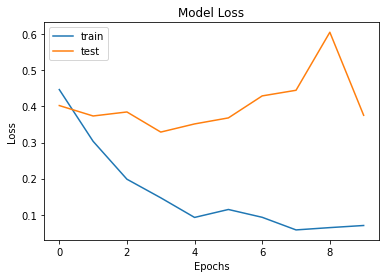

4/4 [==============================] - 0s 32ms/step - loss: 0.4734 - accuracy: 0.8796


In [92]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

evaluation = model.evaluate(x_test,y_test)

In [93]:
prediction = model.predict(x_test)
#print(prediction)
all_predictions  =[np.argmax(result) for result in prediction] 
print(all_predictions)

4/4 [==============================] - 0s 31ms/step
[0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0]
